<a href="https://colab.research.google.com/github/ronyates47/Gedcom-Utils/blob/main/A_v_33_00_YatesStudy_stable_2024_gedcom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install pandas
!pip install python-gedcom
!pip install openpyxl
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: Could not build wheels for pygraphviz, which is required to install pyproject.toml-based projects


In [5]:
import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd

anchor_gen1 = None

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]


def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10] # Use slicing syntax to extract the first 10 characters of the first_name variable
    last_name = last_name[:10].rstrip('/') # Use slicing syntax to extract the first 10 characters of the last_name variable
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

#class Gedcom:
#    def __init__(self, file_name):
#        self.file_name = file_name
#        self.gedcom_datasets = []
#        self.filter_pool = []

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            import pandas as pd  # Assuming you haven't imported it yet
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list,add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

def find_parents(individual_id, generation, records):
    if individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10]
    last_name = last_name[:10].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

def find_distant_ancestors(individual_id, records, path=None):
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

#    print(f"Distant ancestors paths for {individual_id}: {paths}")

    return paths
filtered_datasets = gedcom_instance.filter_pool

#global generation_table
#global visited_pairs

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []

    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))

    return matching_table

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

# Main Loop
for dataset in filtered_datasets:
    individual_id = dataset.get_gen_person()

    visited_pairs = set()
    generation_table = []

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
#    filtered_ancestral_line_str = "|".join(filtered_ancestral_line_names)
#    print(f"Filtered Ancestral Line for {individual_id}: {filtered_ancestral_line_str}")

def process_individual(individual_id, gedcom_instance, records):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.insert(0, anchor_gen1)

    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
    filtered_ancestral_line_str = "~~~".join(filtered_ancestral_line_names)

    individual_data = {
        'cM': cm_value,
        'Sort': sort_value,
        'Filtered Ancestral Line': filtered_ancestral_line_str
    }

    return individual_data, filtered_ancestral_line_str

import pandas as pd

# Global variables
visited_pairs = set()
combined_df_rows = []  # Initialize your empty combined_df_rows list

# Main Loop
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records)
    cm = individual_data['cM']
    sort = individual_data['Sort']
    individual_name = extract_name(records.get(individual_id, ''))
    # Append to DataFrame Rows
    combined_df_rows.append([individual_id, sort, individual_name, cm, filtered_ancestral_line_str])

# Create DataFrame
columns = ['ID#', 'Match to', 'Name', 'cM', 'Yates DNA Ancestral Line']
combined_df = pd.DataFrame(combined_df_rows, columns=columns)

# Initialize Link column
combined_df['Link'] = combined_df['ID#']

# Function to remove the named prefix from the 'Yates DNA Ancestral Line' column
def remove_prefix(row):
    ancestral_line = row['Yates DNA Ancestral Line']
    prefix_to_remove = 'YatesEdmund&CornellMargaret~~~YatesRichard&AshendonJoan~~~YatesJohn&HydeAlice~~~YatesThomas&WhiteFrances~~~'
    if ancestral_line.startswith(prefix_to_remove):
        row['Yates DNA Ancestral Line'] = ancestral_line[len(prefix_to_remove):]
    return row

# Apply the function to remove the prefix
combined_df = combined_df.apply(remove_prefix, axis=1)

# Function to add hotlinks
def create_hotlink(row):
    url_base = "https://yates.one-name.net/tng/verticalchart.php?personID="
    additional_params = "&tree=tree1&parentset=0&display=vertical&generations=15"
    if pd.notnull(row['Link']) and pd.notnull(row['ID#']):
        if '*' in row['Link']:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["Link"]}</a>'
        return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["ID#"]}</a>'
    return ''  # Return an empty string for null values

# Ensure the 'ID#' column exists
if 'ID#' not in combined_df.columns:
    print("Error: 'ID#' column not found in DataFrame")
else:
    # Apply the hotlink function
    combined_df['Link'] = combined_df.apply(create_hotlink, axis=1)
    # Drop the 'ID#' column
    combined_df = combined_df.drop(columns=['ID#'])

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

# Update index and sort
combined_df.index += 1
combined_df.sort_values(by=['Match to', 'Yates DNA Ancestral Line'], ascending=[False, True], inplace=True)

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

combined_df.sort_values(by=['Yates DNA Ancestral Line', 'Match to'], ascending=[False, False], inplace=True)



import pandas as pd
from datetime import datetime

# Assuming combined_df is your DataFrame

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Append the current date and time to your output file names
output_html_path = f'/content/htmloutput_{current_datetime}.html'
combined_df.to_html(output_html_path, index=False, classes='sortable', escape=False)  # Set escape=False to render HTML links

output_excel_path = f'/content/xlsxoutput_{current_datetime}.xlsx'
combined_df.to_excel(output_excel_path, index=False)

# Ensure that combined_df is defined and datetime module is imported



import pandas as pd
##########################################################################################################
##########################################################################################################
##########################################################################################################

Automatically selecting the first GEDCOM file.
GEDCOM contained 55730 total records
Records tagged and filtered by NPFX: 1046
Manual filter IDs loaded: 164
After manual filter, total records: 165
Records tagged and filtered by NPFX: 165


In [6]:
#visualize

import pandas as pd

# Load data from Excel
file_path = '/content/mid-west-nodeFQ-QI.xlsx'  # Adjust as necessary
df = pd.read_excel(file_path, usecols=["cM", "Yates DNA Ancestral Line"])

# Expand the 'Ancestral Line' into separate nodes for each plane, keeping the cM value
expanded_data = []
parents_stack = []  # Stack to keep track of parents at each level
starting_plane = 8  # Define the starting plane for counting

for index, row in df.iterrows():
    nodes = row['Yates DNA Ancestral Line'].split('~~~')
    for i, node in enumerate(nodes):
        plane = i + starting_plane  # Adjust plane numbers starting from 'starting_plane'
        if len(parents_stack) > i:
            parents_stack[i] = node  # Update current level parent
        else:
            parents_stack.append(node)  # Add new level parent

        parent = parents_stack[i-1] if i > 0 else None  # Get parent from stack
        expanded_data.append({'Plane': plane, 'Offspring': node, 'Parent': parent, 'cM': row['cM']})

# Create a DataFrame from the expanded data
expanded_df = pd.DataFrame(expanded_data)

# Filter out planes 1-7
filtered_df = expanded_df[expanded_df['Plane'] >= 8]

# Adjust the Plane numbering to start from 1 for the first relevant plane
filtered_df['Adjusted Plane'] = filtered_df['Plane'] - starting_plane + 1

# Group by 'Adjusted Plane', 'Parent', and 'Offspring' to calculate FQ and mean cM (QI)
results_df = filtered_df.groupby(['Adjusted Plane', 'Parent', 'Offspring']).agg(
    FQ=('Offspring', 'size'),                     # Frequency Quotient: count of each node within its plane
    QI=('cM', 'mean')                             # Quality Index: average of cM values
).reset_index()

# Round QI to nearest integer
results_df['QI'] = results_df['QI'].round(0).astype(int)

# Apply the "2 rule": filter out nodes with FQ less than 2
final_results_df = results_df[results_df['FQ'] >= 2]

# Set hierarchical index
final_results_df.set_index(['Adjusted Plane', 'Parent', 'Offspring'], inplace=True)

# Sort results for better readability
sorted_results_df = final_results_df.sort_values(by=['Adjusted Plane', 'Parent', 'FQ'], ascending=[True, True, False])

# Display sorted results
print(sorted_results_df)

# Optionally, save sorted results to Excel
sorted_results_df.to_excel('sorted_output_results_from_plane_8.xlsx', index=True)


                                                                                   FQ  \
Adjusted Plane Parent                            Offspring                              
2              YatesJohn&SearchingStill          YatesWilliam&SearchingStill      165   
3              YatesWilliam&SearchingStill       YatesWilliam&SearchingStill      165   
4              YatesWilliam&SearchingStill       YatesEdmund&CornellMargaret      165   
5              YatesEdmund&CornellMargaret       YatesRichard&AshendonJoan        165   
6              YatesRichard&AshendonJoan         YatesJohn&HydeAlice              165   
...                                                                               ...   
20             MooreCharlesM&HillEthel           MooreCharlesA&WeatherbyRubyBrow    2   
               PayneJohnMart&GillLauraVio        AlbertaJosephHa&PayneLetaMae       2   
21             AlbertaJosephHa&PayneLetaMae      BrazellLarryRay&AlbertaLetaMae     2   
               Jarboe

In [ ]:
# KEEP THIS TO COMPUTE ANCESTOR IMAGE OUTPUT
#Top 30 Distant Ancestors with Descending Lines)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg


gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list,add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

#    print(f'Records tagged and filtered by NPFX: {len(individuals)}')


#STATS***********************

def generate_pair_stats(df):
    pair_count = {}
    base_position = {}
    total_rows = len(df)

    for idx, row in df.iterrows():
        ancestral_line = row['Yates DNA Ancestral Line']
        pairs = ancestral_line.split('~~')

        for pos, pair in enumerate(pairs, 1):
            pair_count[pair] = pair_count.get(pair, 0) + 1

            if pair not in base_position:
                base_position[pair] = pos

    # Convert to DataFrame
    stats_df = pd.DataFrame(list(pair_count.items()), columns=['Distant Ancestors', 'Descending Lines'])

    # Add Base Position
    stats_df['L-R Location'] = stats_df['Distant Ancestors'].map(base_position)

    # Sort by Frequency
    stats_df.sort_values(by=['Descending Lines', 'L-R Location'], ascending=[False, True], inplace=True)

    # Add Percentage and convert to integer
    stats_df['Percentage'] = (stats_df['Descending Lines'] / total_rows * 100).astype(int)

    # Filter parent pairs with Frequency >= 3
    stats_df = stats_df[stats_df['Descending Lines'] >= 3]

    return stats_df

# Assuming `combined_df` is your DataFrame with 419 rows
stats_df = generate_pair_stats(combined_df)

# Display the statistics
#print("=== Parent Pair Statistics (Count >= 3) ===")
#print(stats_df)

#print("=== Top 30 Distant Ancestors with Descending Lines) ===")
#print(f'Number of Matches with Decending Lines {len(individuals)}')
#print(stats_df.head(30).to_string(index=False))

Automatically selecting the first GEDCOM file.
GEDCOM contained 55567 total records
Records tagged and filtered by NPFX: 1027
filtered_ids.xlsx not found. Skipping second-level manual filter.


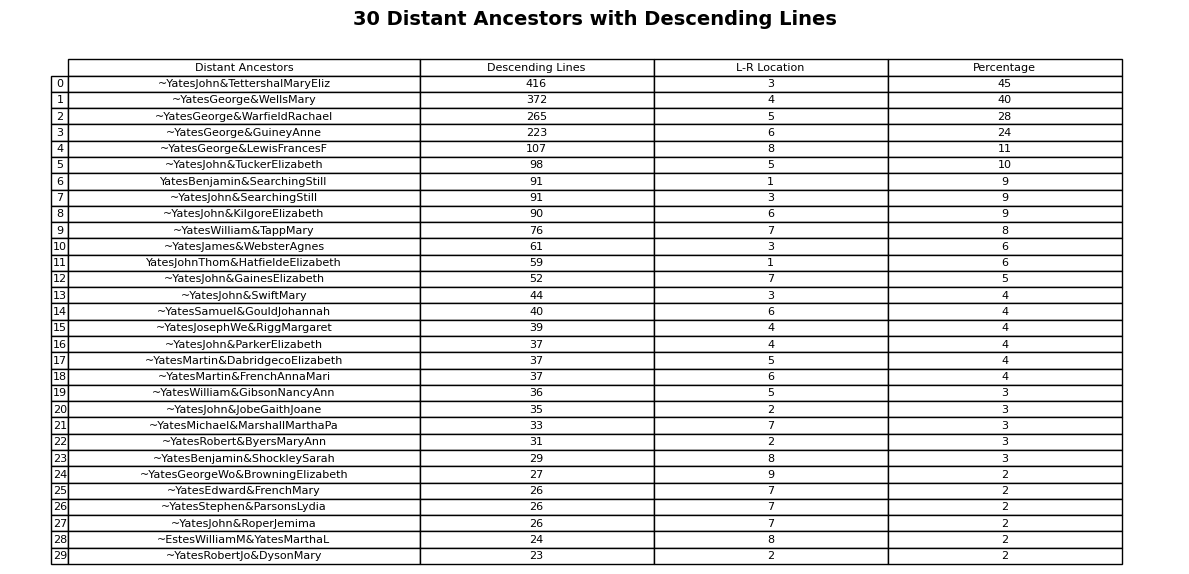

In [ ]:
#GOOD CHART OF 30 ANCESTORS
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import table

# Assuming `combined_df` is your DataFrame with 419 rows
stats_df = generate_pair_stats(combined_df)

# Skip the first two rows of data, then select the next 30 rows and reset the index
# This will give you rows 3 to 32, which are actually the 3rd to 32nd entries due to zero indexing
top_30_df = stats_df.iloc[2:32].reset_index(drop=True)

# Manually specify column widths, adjust these as needed
col_widths = [0.3, 0.2, 0.2, 0.2]

# Create a figure to plot table, adjusting size to ensure it's not compressed
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('off')

# Set the main title
plt.suptitle("30 Distant Ancestors with Descending Lines", fontsize=14, weight='bold')

# Create table with specified column widths
table_ax = table(ax, top_30_df, loc='center', colWidths=col_widths)

# Center align the content in the cells
for cell in table_ax._cells.values():
    cell.set_text_props(ha='center')

# Adjust layout to make room for the title
fig.tight_layout(rect=[0, 0.03, 1, 0.98])

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Append the current date and time to the filename
output_figure_path = f'/content/distant_chart_{current_datetime}.png'

# Save the figure, adjusting bbox_inches to include suptitle and title
plt.savefig(output_figure_path, bbox_inches='tight', pad_inches=0.05)

# Display the figure
plt.show()

# Display the figure
plt.show()

# If you need to download the file, you can use the following code:
#from google.colab import files
#files.download('/content/ancestors_stats_image.png')


In [ ]:
# GOOD for one NAMED PERSON OUTPUT

# Function to add an 'id' attribute to the 'Match to' names for HTML
def add_id_attribute(row):
    match_to_name = row['Match to']
    id_attribute = match_to_name.replace(' ', '_').replace(',', '')
    row['Match to'] = f'<span id="{id_attribute}">{match_to_name}</span>'
    return row

# Apply the function to add the 'id' attribute
combined_df = combined_df.apply(add_id_attribute, axis=1)

# Filter the DataFrame to only include rows where 'Match to' equals 'yates,ronald'
filtered_df = combined_df[combined_df['Match to'].str.contains('yates,ronald')]

# ... (rest of your existing code for DataFrame manipulation)

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Save filtered DataFrame to HTML
output_html_path = f'/content/one-named_people_{current_datetime}.html'
filtered_df.to_html(output_html_path, escape=False, index=False)  # 'escape=False' to render HTML tags

# Print filtered DataFrame
print(filtered_df)


                                       Match to               Name  cM  \
210  <span id="yatesronald">yates,ronald</span>  LeavertonMelissaA  11   
836  <span id="yatesronald">yates,ronald</span>        RayMaryJani  29   
217  <span id="yatesronald">yates,ronald</span>         SmockEldon  10   
461  <span id="yatesronald">yates,ronald</span>     PotterSusanLuc  15   
149  <span id="yatesronald">yates,ronald</span>        GravesGeneL  11   
..                                          ...                ...  ..   
841  <span id="yatesronald">yates,ronald</span>        KellickTara  26   
842  <span id="yatesronald">yates,ronald</span>       DemingTravis  26   
852  <span id="yatesronald">yates,ronald</span>      PhelpsGaryLee  19   
21   <span id="yatesronald">yates,ronald</span>    GregoryDeborahA  33   
857  <span id="yatesronald">yates,ronald</span>    GarrettJackieJo  40   

                                                  Link  \
210  <a href="https://yates.one-name.net/tng/vertic..

In [ ]:
#Good for mid-west persons

from datetime import datetime
import pandas as pd

# Assuming combined_df is your DataFrame that's already been defined

# Function to add an 'id' attribute to the 'Match to' names for HTML
def add_id_attribute(row):
    match_to_name = row['Match to']
    id_attribute = match_to_name.replace(' ', '_').replace(',', '').replace('.', '')
    row['Match to'] = f'<span id="{id_attribute}">{match_to_name}</span>'
    return row

# Apply the function to add the 'id' attribute
combined_df = combined_df.apply(add_id_attribute, axis=1)

# List of names to match
names_to_match = ['yates,ronald', 'yates,andreal', 'yatesjamesrob', 'yates,timoyhyj', 'yates,timothyb', 'yates,patricial', 'wishardglen', 'weeksjerri', 'franch,mike', 'birdwelljac']  # Add or remove names as needed

# Pattern to match any of the names in the list
import re
pattern = '|'.join(names_to_match).replace(',', '\,').replace(' ', '\s')

# Filter the DataFrame to only include rows where 'Match to' matches any name in the list
filtered_df = combined_df[combined_df['Match to'].str.contains(pattern, flags=re.IGNORECASE, regex=True)]

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Save filtered DataFrame to HTML
output_html_path = f'/content/mid-west_people_{current_datetime}.html'
filtered_df.to_html(output_html_path, escape=False, index=False)  # 'escape=False' to render HTML tags

# Print filtered DataFrame
print(filtered_df)



                                              Match to               Name  cM  \
957     <span id="yatestimothyb">yates,timothyb</span>   MottelerSamantha  19   
278         <span id="yatesronald">yates,ronald</span>  LeavertonMelissaA  11   
539         <span id="yatesronald">yates,ronald</span>     CondryPaulannI  10   
792   <span id="yatespatricial">yates,patricial</span>       YatesMichael  11   
1043         <span id="birdwelljac">birdwelljac</span>             BurchS  15   
...                                                ...                ...  ..   
914         <span id="yatesronald">yates,ronald</span>        KellickTara  26   
915         <span id="yatesronald">yates,ronald</span>       DemingTravis  26   
577            <span id="weeksjerri">weeksjerri</span>        EvansDeidre  30   
1003           <span id="weeksjerri">weeksjerri</span>      JohnsonLeeAnn  24   
228       <span id="yatesandreal">yates,andreal</span>      JonesMaryKath  23   

                           

In [ ]:
#Good for New Jersey persons

from datetime import datetime
import pandas as pd

# Assuming combined_df is your DataFrame that's already been defined

# Function to add an 'id' attribute to the 'Match to' names for HTML
def add_id_attribute(row):
    match_to_name = row['Match to']
    id_attribute = match_to_name.replace(' ', '_').replace(',', '').replace('.', '')
    row['Match to'] = f'<span id="{id_attribute}">{match_to_name}</span>'
    return row

# Apply the function to add the 'id' attribute
combined_df = combined_df.apply(add_id_attribute, axis=1)

# List of names to match
names_to_match = ['yatesjohnh', 'girtain,Alma', 'girtain,andy', 'girtain,kathryn', 'girtain,theresa', 'girtja', 'girtjos' ]  # Add or remove names as needed

# Pattern to match any of the names in the list
import re
pattern = '|'.join(names_to_match).replace(',', '\,').replace(' ', '\s')

# Filter the DataFrame to only include rows where 'Match to' matches any name in the list
filtered_df = combined_df[combined_df['Match to'].str.contains(pattern, flags=re.IGNORECASE, regex=True)]

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Save filtered DataFrame to HTML
output_html_path = f'/content/new-jersey_people_{current_datetime}.html'
filtered_df.to_html(output_html_path, escape=False, index=False)  # 'escape=False' to render HTML tags

# Print filtered DataFrame
print(filtered_df)



                                             Match to              Name  cM  \
246          <span id="yatesjohnh">yates,johnh</span>    PerkinsTeresaG  13   
422  <span id="girtaintheresa">girtain,theresa</span>   RussellPatsyAnn   9   
408  <span id="girtainkathryn">girtain,kathryn</span>  ChildersPeggySue  12   
394        <span id="girtainalma">girtain,alma</span>     FlintAshleyJo  10   
396        <span id="girtainalma">girtain,alma</span>   DockeryNicoleMa  10   
..                                                ...               ...  ..   
430  <span id="girtainkathryn">girtain,kathryn</span>   StevensGregoryL  91   
428  <span id="girtainkathryn">girtain,kathryn</span>    PalmerMayhughJ   9   
189        <span id="girtainalma">girtain,alma</span>       FitchJeanee  18   
983  <span id="girtainkathryn">girtain,kathryn</span>     BurchNaomiEug  25   
979           <span id="yatesjohnh">yatesjohnh</span>     SloverDeborah  25   

                                                  L